# Predicting Why Employees Leave

# Definition

## Abstract
Measuring employee satisfaction is a tough and highly complex task. There are a lot of different dimensions in play and turning them into quantifiable format, less to say machine-readable information, can pose a challenge. Information from employee reviews, demographics, balanced scorecards and key performance indicators can offer a first gateway to understanding employee turnover. Modern machine learning algorithms offer tools to leverage this pool of information and extract actionable insights regarding employee behaviour. In this research a model is introduced using supervised and unsupervised algorithms to predict employee turnover. The novelty of the work is in the hybrid approach leveraging both unsupervised and supervised learning results. Based on recent research it was possible to increase the prediction outcome and to introduce a hybrid model that could work as a blueprint for similar tasks in this domain.



## Introduction

According to the [Bureau of Labor Statistics](http://www.bls.gov/news.release/tenure.nr0.htm) the median number of years that wage and salary workers had been with their current employer is 4.2 years \cite{labor1:bls}. While this number varies from industry to industry the story of an employee who sticks with one company for the entirety of a working life seems to be rather antiquated. This observation is combined with economical aspects. Employee turnover has been identified as a key issue for organizations because of its adverse impact on work place productivity and long term growth strategies <cite data-cite="4046282/DZ7FB7XU"></cite>. One of the key issues with a high employee turnover rate combined with, but reaching beyond, cultural and sociological effects is the cost associated with it. Research shows that the replacement cost for an hourly worker can be as high as 50\% of her annual salary. This number increases with the skill set of the worker up to 200\% for senior-level workers and surges up to 400\% for [executive level positions](www.visier.com/tech-insights/do-predictive-workforce-analytics-actually-work/). It becomes obvious that the trend of shorter tenure in addition to high employee turnover rates can be a costly endeavour. Therefore it becomes increasingly important to acquire the necessary tools for employers to understand where its workforce is standing. Additional insights from employee reports, scorecards as well as general statistical information can offer prediction values for companies when it comes to the longevity of jobs. This research aims to predict the likelihood of an employee quitting her job based on available information. It tries to deliver a hybrid machine learning method to gain actionable insights on how to prevent a high employee turnover. The novel contribution of this paper is the usage of a two-layered approach using unsupervised and supervised machine learning algorithms to achieve a higher predictive outcome.

## Literature Review
Employee turnover is a high impact topic and has been researched in both, management as well as psychology studies. Employee turnover can be defined as "the gross movement of workers in and out of employment with respect to a given company" <cite data-cite="4046282/4E5VI8HP"></cite>. According to the Bureau of Labor Statistic there are two categories of turnover. Employee turnover is measured in terms of persons that quit their job, also known as voluntary turnover, and total separations. The subtraction of both numbers resulting in the amount for involuntary turnover. This research focuses on voluntary turnover and the reason behind it. Research suggests four categories of factors when it comes to employee turnover. Organization-wide factors, immediate work environment factors, job-related factors, and personal factors <cite data-cite="4046282/HPCFW2W5"></cite>.
<cite data-cite="4046282/I6B68G3U"></cite> indicate in their model a multi-layered approach to turnover motivators including traditional features such as job satisfaction, meeting of expectations or job involvement as well as newer attitudes like stress, psychological uncertainty, challenge, hindrance stressors or organizational context like company size, group cohesion and demography. Adding to the complexity of the field, research has shown, that turnover rates are also affected by moderating factors. General job availability, movement of capital and job satisfaction can interact with each other simultaneously to affect turnover <cite data-cite="4046282/5P9K6ZAZ">. Personal traits tend to have moderating effects as well. The relationship between turnover intentions and turnover for example can be moderated by various personality traits. This relationship was found to be stronger for employees with low self-monitoring, low risk aversion, and an internal locus of control <cite data-cite="4046282/SJ3BZIGV"></cite>.
Some research explored the relationship between job satisfaction and turnover and found it to be significant and consistent, but not particularly strong <cite data-cite="4046282/E5IGJ7T9"></cite>. Capturing all these dimensions stays a problem. A more complete understanding of the psychology of the withdrawal decision process requires investigation beyond the replication of the satisfaction–turnover relationship. <cite data-cite="4046282/UZ4GGATW"></cite> recommend a thorough comparison of several models and data exploration. Explicitly stating the need to continue model testing rather than simply correlating variables with turnover. <cite data-cite="undefined"></cite> have found that most studies of voluntary turnover have one or two independent variables with voluntary turnover as the dependent variable. Machine learning algorithms are offering the opportunity to handle complex data structures and a large amount of variables. After capturing the needed data, machine learning can facilitate the ground truth hidden in massive data sets. 

## Problem Statement
Machine learning differentiates between two classification problems. In some cases the data set contains unstructured data and machine learning is used to find clusters or classes. In other cases there are certain already predefined classes or labels. The task is to search for relationships or rules to distinguish one class from another. The first category of classification is called unsupervised learning. The second category falls into supervised learning. This research deals with a binary prediction task, to detect whether an employee has left the company or is still employed. But since employee turnover research is maneuvering in a highly interdependent context, the underlying relationship between features are important. In an attempt to create employee clusters and to use them in the prediction task, this research wants to offer a way of visualizing and categorizing employee behaviour.
The problem to be solved is detecting the key elements of employee tenure and predicting whether an employee might be quitting her job. The setup of this research can be seen as a classification problem. Based on a set of features our solution should be able to determine if an employee quits or stays with a company. The core path to solving this problem is a supervised learning approach which will test the relationship between our independent variables and our dependent variable (did an employee leave or stay). The high-level tasks involved are the following:

1. Download and preprocess the kaggle dataset about employment
2. Use statistical methods such as descriptive analysis, regression and/or correlation to lay groundwork.
3. Train a clustering algorithm to group employees into different segments. 1
4. Train a classifier that determines whether an employee has left. 5. Compare our results against the benchmark model.

A desirable solution can be quantified by correct detection of potential job quitters and the amount of created intervention opportunities. This problem affects companies of all sizes. Although it can be said that based on statistics there are certain industry traits that have a higher tenure the tendency to switch jobs has increased over time. The boundaries of this problem are the underlying mechanisms of every individual company. It is also important to mention that prediction is not equal to prevention. Company culture, direct reports and individual needs might turn out to be far more complicated than a list of features. However, if this problem is detected and fixed the path to a more successful and sustainable company culture is given. It shall be stated that a mechanism such as this can only work as a supplement to human interaction and empathy skills.

## Solution Statement
First an in-depth exploratory analysis is performed in an attempt to explain the underlying relationships in the data set. Afterwards the problem is approached on two dimensions by combining unsupervised and supervised learning algorithms:

1. Two clustering algorithms namely K-Means or Gaussian Mixture Model will be discussed in an attempt to add more semantic to the employee set. Since the problem is based in a sociological domain, the more we can derive from our feature set, the more human interaction and perception we can gather, the better. By clustering, we might be able to hand additional information to the supervised algorithm for a better prediction down the road.
2. Afterwards features and additional cluster-information are used to predict whether an employee left or stayed. Given that the data is labeled and considering the amount of data points, a range of algorithms is discussed starting with more basic solutions and working towards more complex methods.

The solution is trying to implement a model that will empower employers not only to detect, which of their own employees is about to leave the company but also determine which of the features contributes the most to a happy company culture. The success of the final solution however will be measured by its predicting accuracy on a held-out test set.

## Benchmark
As mentioned earlier, a lot of research and work has been performed to retain talent and decrease employee turnover rates. From corporate funded research and [analytics services of companies](www.visier.com/tech-insights/do-predictive-workforce-analytics-actually-work/) to management study classics <cite data-cite="4046282/UZ4GGATW"></cite> or more recent research <cite data-cite="4046282/DZ7FB7XU"></cite>. There are several methods for predicting employee turnover rate and results that can be taken as benchmark models. In this research the machine learning approach of <cite data-cite="4046282/DZ7FB7XU"></cite> serves as a benchmark. Their research performed predictive tasks on company information with an area under the curve (AUC) score of .86 on hold-out data implementing an Extreme Gradient Boosting model.

### Evaluation Metrics
AUC (Area under the Curve) is a common evaluation metric for binary classification problems. Its value is between 0 to 1 and describes the accuracy of a binary classification based on its true positive values. As [described](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve), an area under the curve score is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.

Area under the curve (AUC) is a common evaluation metric for binary classification problems. Its value is between 0 to 1 and describes the accuracy of a binary classification based on its true positive values. An [AUC score](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.

To put this more into perspective [AUC](https://www.kaggle.com/wiki/AreaUnderCurve) can be seen as a plot of the true positive rate vs. the false positive rate where the threshold value for classifying an item as 0 or is increased from 0 to 1. If the classifier is very good, the true positive rate will increase quickly and the area under the curve will be close to 1. If the classifier is no better than random guessing, the true positive rate will increase linearly with the false positive rate and the area under the curve will be around 0.5 <cite data-cite="4046282/M4CWJ7CZ"></cite>.

### AUC vs. F1 Score
There is some controversy about the value of AUC scores. Especially when it comes to precision and recall it is possible for a classifier to have a low recall but a very high AUC score. To avoid this, F1 scoring can be used which is a way to incorporate both precision and recall. For a F1 score to be high, both, precision and recall have to be high. The problem of a low recall score will be addressed for the leading model when testing for robustness.

# Analysis
In a data set published on [Kaggle](https://www.kaggle.com/ludobenistant/hr-analytics), information on current and former employees is offered plus key features of their employment status. Unfortunately there is no available code book besides a brief information on the available inputs. The data set contains 14,999 data points and 10 variables. 

Since there is no additional information regarding the data set we are starting with some assumptions about the variables based on their description. Information that's comprised in this data set seems to include a measure of employee satisfaction level, evaluation scores, amount of projects, average monthly hours spend on the job, overall time spent at the company, whether the employee had a work accident or received a promotion within the last 5 years, a description of the department the employee works for and a salary indicator. In addition there is a variable called left that indicates, whether an employee is still actively working for this company or not. This indicator will be seen as the dependent or target variable that is being predicted.

## Data Exploration
As mentioned earlier, there is no code-book that can be linked to this data set. Since there is no additional information regarding the data set some assumptions about the variables are made based on their description. A sample of the data looks like this:

In [1]:
# Read in data & import of packages & frameworks
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline

from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.layouts import column, row
from bokeh.plotting import reset_output
from bokeh.charts.attributes import cat
from collections import Counter
from IPython.display import display

plot_color = 'crimson'
cmap = sns.diverging_palette(222, 10, as_cmap=True)

hr_data = pd.read_csv('data/HR_comma_sep.csv', header=0)

In [2]:
# Rename column to fit better, get rid of typos and instill consistency
hr_data = hr_data.rename(
    columns = {'sales' : 'department', 
               'average_montly_hours' : 'average_monthly_hours',
               'Work_accident' : 'work_accident'})

In [3]:
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


First, let's have a look at how much data we're dealing with and how it's structured.

In [4]:
print "The data set has {} data points and {} variables.".format(*hr_data.shape)

The data set has 14999 data points and 10 variables.


In [5]:
print hr_data.columns.values

['satisfaction_level' 'last_evaluation' 'number_project'
 'average_monthly_hours' 'time_spend_company' 'work_accident' 'left'
 'promotion_last_5years' 'department' 'salary']


Given by its column names we have 10 variables that need to be taken into account. Since there is no additional information regarding the data set we are starting with some assumptions about the variables based on their description. Information that's comprised in this data set seems to include a measure of employee satisfaction level, evaluation scores, amount of projects and average monthly hours spend on the job, overall time spent at the company, whether the employee had a work accident or received a promotion within the last 5 years, a description of the department the employee works for and a salary indicator. In addition there is a variable called `left` that indicates, whether an employee is still actively working for this company or not.
In addition the dataset provides an indicator whether an employee has left. This indicator will be seen as the dependent variable that is being predicted.
This indicator will be seen as the dependent variable that is being predicted.



As a first summary, the predictors we will be using consist of:

* Employee satisfaction level 
* Last evaluation score
* Number of projects
* Average monthly hours
* Time spent at the company
* Whether they have had a work accident
* Whether they have had a promotion in the last 5 years 
* Department
* Salary

The target variable is `left`.

### Variable Description
As mentioned earlier, there is no codebook that can be linked to this data set. And since there is no additional information regarding the data set we are starting with some assumptions about the variables based on their description.

In [6]:
hr_description = hr_data.describe()
hr_description

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [7]:
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


A brief summary of the numeric values in the data set offers following insights about the variables:

* **satisfaction_level:** 1 most likely indicating a high satisfaction level [continuous value in the range of 0 and 1]
* **last_evaluation:** Most likely the rating of given employee [continuous numeric value between 0 and 1]
* **number_project:** The amount of projects an employee has. [discrete numeric value between 2 and 7]
* **average_monthly_hours:** The hours an employee works per month [continous numeric value between 96 and 310]
* **time_spend_company:** Given current working statistics we are most likely dealing with years. [discrete numeric value between 2 and 10]
* **work_accident:** Numeric expression of boolean value whether an employee had a work accident [discrete: 1 = true, 0 = false]
* **left:** Label if person left or not [discrete: 1 = true, 0 false]
* **promotion_last_5years:** Numeric expression of boolean value whether an employee was promoted within the last 5 years [discrete: 1 = true, 0 = false]

The dataset contains some non-numeric variables as well that need further exploration. `department` and `salary` have character values that seem to describe the data points further.

In [8]:
# Describe categorical data
print "hr_data['department']:", hr_data['department'].unique(), '\n'
print "hr_data['salary']:", hr_data['salary'].unique()

hr_data['department']: ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD'] 

hr_data['salary']: ['low' 'medium' 'high']


This completes the variable descriptions and offers additional insights:

* **department:** Categorical variable describing the position of an employee. [discrete: sales, accounting, hr, technical, support, management, IT, product_mng, marketing, RanD]
* **salary:** Categorical variable indicating salary level of employee. [discrete: low, medium, high]

### Mean vs median
In order to decide whether to pick the mean or median values for comparison, we'll be computing the variance of each option.

In [9]:
# Mean or median
mean_by_dept = hr_data.groupby('department').mean()
median_by_dept = hr_data.groupby('department').median()

mm_comp = []
index = []
for row_mean, row_median in zip(mean_by_dept.var().iteritems(), median_by_dept.var().iteritems()):
    mm_comp.append([row_mean[1], row_median[1]])
    index.append(row_mean[0])

mm_comp = pd.DataFrame(mm_comp, columns=['mean', 'median'], index=index)
mm_comp

,mean,median
satisfaction_level,0.000157,0.000291
last_evaluation,0.000028,0.000143
number_project,0.005299,0.000000
average_monthly_hours,1.376778,4.011111
time_spend_company,0.077200,0.000000
work_accident,0.000276,0.000000
left,0.002177,0.000000
promotion_last_5years,0.001051,0.000000


There is clearly more information gain from the mean values in our data set. We'll be continuing using average values for our analysis where needed.

In [10]:
hr_description.transpose()[['std', 'min', 'max']]

,std,min,max
satisfaction_level,0.248631,0.09,1.0
last_evaluation,0.171169,0.36,1.0
number_project,1.232592,2.00,7.0
average_monthly_hours,49.943099,96.00,310.0
time_spend_company,1.460136,2.00,10.0
work_accident,0.351719,0.00,1.0
left,0.425924,0.00,1.0
promotion_last_5years,0.144281,0.00,1.0


### Univariate Analysis
Next all variables are explored one-by-one. The method used depends on whether the variable is continuous or discrete. For continuous variables the spread and central tendency is important. For discrete variables frequency and histograms will be used to gain additional information. 

Based on the numeric information about mean, minimum and maximum values it can already be said that the numeric values seem to contain only little anomalies when it comes to tendency. The standard deviation values indicate a balanced dispersion. In order to visualize the findings. Density plots will further help investigate the distribution.

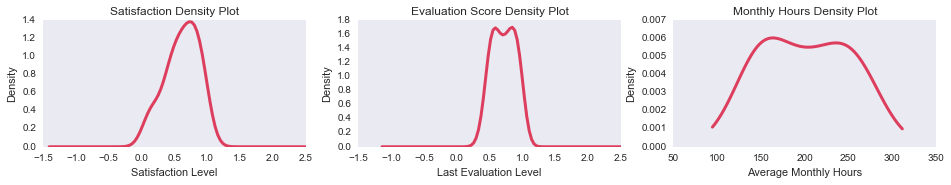

In [11]:
sns.set_style('dark')
plt.figure(figsize=(16, 5))
plt.subplot(231)
ax1 = sns.kdeplot(hr_data['satisfaction_level'], bw=.5, color="#de3e5e", linewidth=3)
ax1.set_xlabel('Satisfaction Level')
ax1.set_ylabel('Density')
ax1.set_title('Satisfaction Density Plot')
ax1.legend_.remove()
plt.subplot(232)
ax2 = sns.kdeplot(hr_data['last_evaluation'], bw=.5, color="#de3e5e", linewidth=3)
ax2.set_xlabel('Last Evaluation Level')
ax2.set_ylabel('Density')
ax2.set_title('Evaluation Score Density Plot')
ax2.legend_.remove()
plt.subplot(233)
ax3 = sns.kdeplot(hr_data['average_monthly_hours'], bw=.5, color="#de3e5e", linewidth=3)
ax3.legend_.remove()
ax3.set_title('Monthly Hours Density Plot')
ax3.set_xlabel('Average Monthly Hours')
ax3.set_ylabel('Density')

Given that the density curve describes the relative likelihood for a random variable to take on a given value, following observations can be made. With some smoothing, the `satisfaction_level` seems to be pretty normal in regards of distribution. Both `last_evaluation` as well as `average_monthly_hours` have two peaks. Yet there is no anomaly in the dibstribution.

The discrete variables can be explored with 

In [12]:
#plt.figure()
#plt.subplot(221)
#pd.DataFrame.from_dict(Counter(hr_data['department']), orient='index').plot()
cols = ['number_project', 
        'time_spend_company', 
        'department', 
        'salary', 
        'work_accident', 
        'left', 
        'promotion_last_5years']
col_dict = {}
for col in cols:
    col_dict[col] = pd.DataFrame.from_dict(Counter(hr_data[col]), orient='index')
    col_dict[col].columns = [col]

In [13]:
#discrete_vars = hr_data[['department', 'salary']]
from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.layouts import column, row
from bokeh.plotting import reset_output
from bokeh.charts.attributes import cat
from collections import Counter
from IPython.display import display
row_coll = []
rows = []
block = True

for column in cols:
    block = True
    column_title_split = column.split('_')
    column_title = ""
    for column_title_piece in column_title_split:
        column_title += " " +column_title_piece.title()
    
    p = Bar(col_dict[column], 
            values=column, 
            title=column_title + ' Stats',
            color=plot_color,
            plot_width=300, 
            plot_height=200,
            ylabel="",
            legend=None,
            toolbar_location=None)
    rows.append(p)
    if len(rows) == 3:
        block = False
        row_coll.append(list(rows))
        reset_output()
        rows = []

if block:
    row_coll.append(list(rows))
    
#print row_coll
gridplot = gridplot(row_coll)
output_notebook()
show(gridplot)

Loading BokehJS ...

In [14]:
#from math import round
print "{:.2f} % percent of all employees had a promotion within the last 5 years.".format(
    (len(hr_data[hr_data['promotion_last_5years'] == 1]) / 
    float(len(hr_data['promotion_last_5years']))) * 100)
print "{} out of 100 employees had a work related accident.".format(int(round((len(hr_data[hr_data['work_accident'] == 1]) / float(len(hr_data))) * 100)))

2.13 % percent of all employees had a promotion within the last 5 years.
14 out of 100 employees had a work related accident.


Looking at the frequency plots the `number_project` and `time_spend_company` distribution have a slight positive skew. It can be seen that the most employees tend to have 3 or 4 projects and tenure seems to level around 3 years. When it comes to `department`, the most employees are employed in sales with technical coming second and support being third on the list. The `salary` variable shows a clear skew towards low and medium wages what was to be expected. When it comes to work accidents, the data shows about 14 in 100 employees has had a work related accident. Even more severe is the skew when it comes to promotions. Only 2 out of 100 employees have had a promotion in the last 5 years. A slightly less severe but still significant skew is happening in the dependent variable `left`. This needs to be taken into account when splitting the data set for training, cross validation and training. 

### Missing Values
Another problem that might occur are missing values. 

In [15]:
# Check if there are any NaN values
for name, item in hr_data.isnull().sum().iteritems():
    if item > 0:
        print name

There are no missing values in the data set, which is fortunate.

## Data Context
To get a firmer grasp on some of the information hidden in the data set it's helpful to ask questions regarding the context of the data. Simple questions help putting a perspective on the information and offer a gateway to understanding the data. Questions that are being answered by this section are:

* How many people left their company?
* What's the average tenure?
* How do variables change by department?
    * Which department works the most hours?
    * Where do most work accidents appear?
    * What is the satisfaction level by department?

### How many people left their company
Let's see how the distribution of our indipendent variable looks like. It's important to note that we'll need a similar distribution of this variable for our training and testing sets.

In [16]:
people_left = len(hr_data[hr_data['left'] == 1])
print "{} Persons left their company ({:.3} %)".format(
    people_left, ((people_left/float(len(hr_data))) * 100))

3571 Persons left their company (23.8 %)


### What's the average tenure over all departments

In [17]:
# Average tenure
print "Average tenure: {:.4}".format(hr_data['time_spend_company'].mean())

Average tenure: 3.498


It shows that people in our data set tend to leave the company earlier than the average depicted in the first paragraph. Which could indicate that the population we're looking at is either younger than the average work force or, more likely, that we're not representing state and federal employees which tend to have a way higher tenure (> 8 years).

### Exploration by department
In order to get a better grasp on the information that is contained in the data set, we'll be looking at the predictors through the eyes of each department.

In [18]:
from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.layouts import column, row
from bokeh.plotting import reset_output
from bokeh.charts.attributes import cat
from collections import Counter
from IPython.display import display
row_coll = []
rows = []
counter = 1

for column in mean_by_dept.columns:
    column_title_split = column.split('_')
    column_title = ""
    for column_title_piece in column_title_split:
        column_title += " " +column_title_piece.title()
    
    p = Bar(mean_by_dept, 
            values=column, 
            title='Average' + column_title + ' by department',
            color=plot_color,
            plot_width=300, 
            plot_height=200,
            ylabel="",
            legend=None,
            toolbar_location=None)
    rows.append(p)
    if len(rows) == 3:
        row_coll.append(list(rows))
        reset_output()
        rows = []
    
row_coll.append(list(rows))
    
#print row_coll
gridplot = gridplot(row_coll)
output_notebook()
show(gridplot)

Loading BokehJS ...

#### Insights by department
* The satisfaction level seems to be quite consistant over all departments. Only **accountants** & **HR** have a slight below average satisfaction level.
* Evaluation levels are on a consistant level over all departments.
* **HR** & **Marketing** seem to have slightly below average number of projects.
* All departments seem to clock in the same amount of time on a monthly basis. Guess there are only so much hours to the week. 
* **Management** is the clear frontrunner, when it comes to tenure. This makes sense, since a management position comes with greater responsibility & lock-in effects.
* **R&D**, **Management**, **Marketing** & **Support** seem to have the most hazardous work environment. With **Accounting** & **HR** being on the safety first side.
* **Management** & **R&D** have the highest average loyalty rate. **Accounting** & **HR** on the other hand are fluctuating quite a bit.
* **Management** have by far the highest promotion rate. In **Marketing** almost one out of two has had a promotion within the last 5 years, in the **R&D** department over 30 % has advanced on a professional level in the last 5 years. The **Support** and **Technical** departments are on the lowest spectrum.

## Bi-variate Analysis
It's good practice to get a grasp on how the variables are behaving in concert with each other. The relationship between two variables can tell us a lot about possible hypotheses that might be hidden in the data. In order to leverage this part of the analysis to its full extend One-Hot encoding will be performed for all discrete character filled variables, which is a step featured in the **Data Preprocessing**.

In [19]:
def preprocess_features(data):
    ''' 
    Preprocesses input data. 
    converts non-numeric binary variables into
    binary (0/1) variables. 
    Converts categorical variables into dummy variables. 
    '''
    output = pd.DataFrame(index = data.index)

    # Investigate each feature column for the data
    for col, col_data in data.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
        # Unify all column names by transforming to lower case
        output.columns = output.columns.str.lower()
    
    return output

hr_data = preprocess_features(hr_data)

print "Processed feature columns ({} total features):\n{}".format(
    len(hr_data.columns), list(hr_data.columns))

Processed feature columns (21 total features):
['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'work_accident', 'left', 'promotion_last_5years', 'department_it', 'department_randd', 'department_accounting', 'department_hr', 'department_management', 'department_marketing', 'department_product_mng', 'department_sales', 'department_support', 'department_technical', 'salary_high', 'salary_low', 'salary_medium']


## Regression & Correlation 

After encoding and preprocessing the data set we're curious in how the variables work with each other. This might be especially insightful when deciding which features to include or exclude. This is an important step to understanding what measures might be helpful when trying to prevent a high leaving rate.

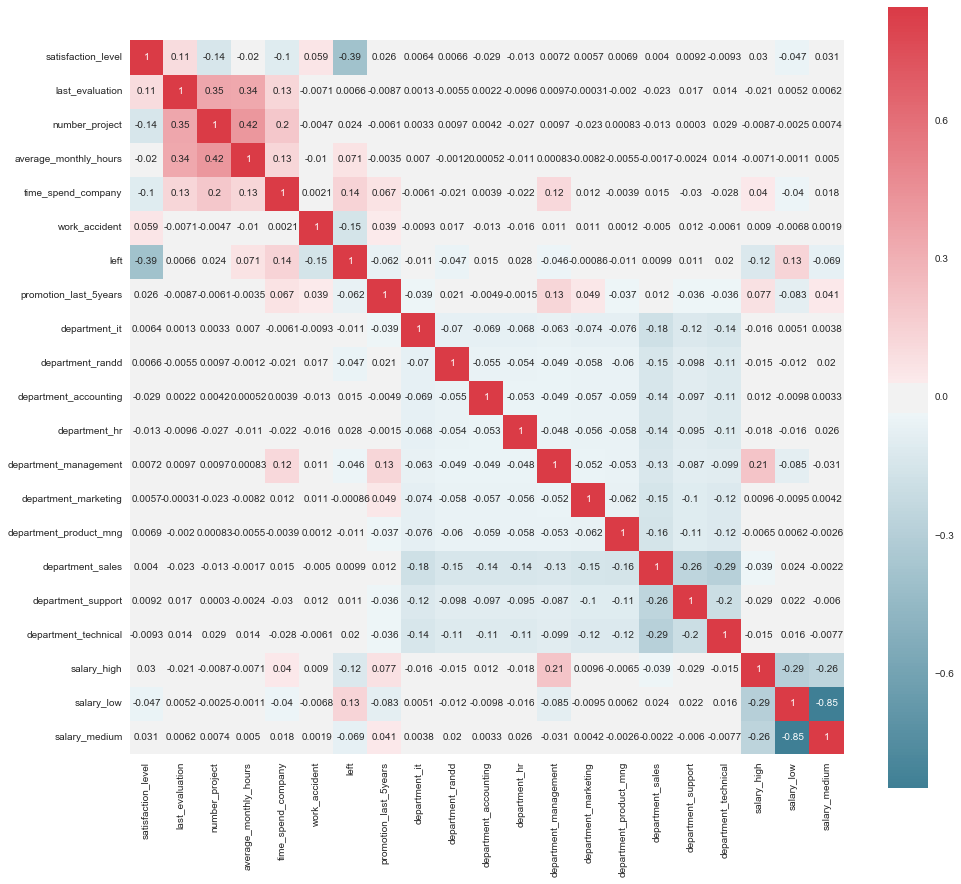

In [20]:
plt.figure(figsize=(16, 14))
cmap = sns.diverging_palette(222, 10, as_cmap=True)
_ = sns.heatmap(hr_data.corr(), annot=True, vmax=.8, square=True, cmap=cmap)

Just based on the heatmap there are already a couple of interesting observations one can make.

* A high satistfaction level seems to lead to a lower leaving rate.
* Employees with higher salary are less inclined to leave.
* On the other hand low salary employees seem to leave the company more often. 
* There's a positive correlation between the time a person spends at a company and the fact if they left.

But in order to get more granular we are interested in the highly correlated (strength > .1) and highly significant (p-Value > 0.05) connections.

In [21]:
def corr_table(data, features, sig_level=0.05, strength=0.0):
    import math
    import numpy as np
    from scipy.stats import pearsonr

    from operator import itemgetter
    p_val_dict = []
    check_dict = []
    for feature in features:
        feature_first = feature.split('_')[0]
        for label in features:
            # Since these correlations go in both directions, we only need to store on 
            # of the correlations and can discard the secon one
            # i.e. corr(age, Medu) has equal insights to corr(Medu, age)
            feature_comb = label+feature
            label_first = label.split('_')[0]
            
            if feature == label or feature_comb in check_dict or feature_first == label_first:
                #feature is already paired with label or equals label
                #or feature and label are from the same one-hot-encoding category
                continue
            else:
                check_dict.append(feature+label)
                pears = pearsonr(data[feature], data[label])
                p_val = pears[1]
                corr_strength = pears[0]
                cov_strength = np.cov(data[feature], data[label])[0][1]
                
                # Check if correlation is significant and has a high enough correlation
                if p_val < sig_level and math.fabs(corr_strength) > strength:
                    p_val_dict.append([feature, label, cov_strength, corr_strength, p_val])

    p_corr_title = 'Correlation > ' + str(strength)
    p_value_title = 'p-Value < ' + str(sig_level)
    p_val_dict = pd.DataFrame(p_val_dict, columns = ['Feature', 'Label', 'Covariance', p_corr_title, p_value_title])
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    p_val_dict['order'] = abs(p_val_dict[p_corr_title])
    p_val_dict.sort_values(by='order', inplace=True, ascending=False)
    p_val_dict.head()
    p_val_dict = p_val_dict.reset_index(drop=True)
    p_val_dict = p_val_dict.drop('order', axis=1)
    
    return p_val_dict



In [22]:
reg_features = hr_data.columns[~hr_data.columns.str.contains('left')]
label = reg_features

# How many significant correlations are in the data set?
correlations_all = corr_table(hr_data, reg_features, strength=0.1)

In [23]:
correlations_all

,Feature,Label,Covariance,Correlation > 0.1,p-Value < 0.05
0,number_project,average_monthly_hours,25.6833,0.4172,0.0000
1,last_evaluation,number_project,0.0737,0.3493,0.0000
2,last_evaluation,average_monthly_hours,2.9044,0.3397,0.0000
3,department_management,salary_high,0.0115,0.2091,0.0000
4,number_project,time_spend_company,0.3542,0.1968,0.0000
5,satisfaction_level,number_project,-0.0438,-0.1430,0.0000
6,last_evaluation,time_spend_company,0.0329,0.1316,0.0000
7,promotion_last_5years,department_management,0.0037,0.1281,0.0000
8,average_monthly_hours,time_spend_company,9.3164,0.1278,0.0000
9,time_spend_company,department_management,0.0338,0.1154,0.0000


Based on our correlation analysis we can infer the following observations:
* Employees with a higher number of project tend to have a significant higher work load per month.
* A high evaluation level leads to an increase in the amount of projects (and therefore an increased monthly workload)
* People from the management department tend to have a higher salary
* An increase of number of project tends to a higher tenure rate.
* A low number of projects has a negative correlation with the satisfaction level.
* If the last evaluation was higher, the person was more likely to stay.
* As mentioned above, people from the management department tend to have a higher promotion rate.
* A high effort, measured by an average monthly hours, leads to a significant higher retention rate.
* People in management jobs have a higher tenure.
* A high last evaluation has a positive impact on the satisfaction level.
* A low satisfaction level has a negative correlation with the time an employee stays at a company.

### Outlier Detection
Another problem that might occur in a data set are outliers. Outliers can lead to wrong estimations and poor performance on some of the algorithms available. Simply put, an outlier is a data point that seems to be out of the normal when it comes to a variable or even multiple variables at once. Usually outliers can be univariate or multivariate which means that their abnormal values can either happen on one dimension or multiple variable dimensions. Going on the focus will be on univariate outliers.
The initial value to detect outliers used in this analysis is a 1.5 multiple of the Inner Quartile Range.

In [24]:
# Outlier detection
outliers = {}
outliers_all = []
sum = 0
# For each feature find the data points with extreme high or low values
for feature in hr_data[[0,1,2,3,4]].keys():
    
    # Calculates Q1 for the given feature
    Q1 = np.percentile(hr_data[feature], 25)
    
    # Calculates Q3 for the given feature
    Q3 = np.percentile(hr_data[feature], 75)
    
    # Calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    # Display the outliers
    category_outliers = hr_data[~((hr_data[feature] >= Q1 - step) & (hr_data[feature] <= Q3 + step))]
    for outlier_no in category_outliers.index:
        if outlier_no in outliers:
            outliers[outlier_no] += 1
        else:
            outliers[outlier_no] = 1
            outliers_all.append(outlier_no)
    if len(category_outliers) > 0:
        print ""
        print "Data points considered outliers for the feature '{}' - (Min: {} - Max: {}):".format(feature, Q1, Q3)
        print "Outliers: {} ({:.2f} %)".format(len(category_outliers), 
                                              (len(category_outliers) / float(len(hr_data))) * 100 )
    else:
        print "No outliers for feature '{}'.".format(feature)
    #display(category_outliers)

No outliers for feature 'satisfaction_level'.
No outliers for feature 'last_evaluation'.
No outliers for feature 'number_project'.
No outliers for feature 'average_monthly_hours'.

Data points considered outliers for the feature 'time_spend_company' - (Min: 3.0 - Max: 4.0):
Outliers: 1282 (8.55 %)


The data looks pretty clean already, there are only outliers in the category `time_spend_company`. These outliers account for around 8.55 % of the overall data set. In order to determine if they should be removed from the data set we'll be looking more carefully. By increasing the tolerance for outliers, additional variance might be added but it gives us the opportunity to keep more data for our algorithms.

In [25]:
steps = [1.5, 2, 2.5, 3, 4, 5]

outlier_index = {}
for step_count in steps:
    outlier_data = hr_data['time_spend_company']
    Q1 = np.percentile(outlier_data, 25)
    Q3 = np.percentile(outlier_data, 75)
    step = step_count * (Q3 - Q1)
    category_outliers = hr_data[~((outlier_data >= Q1 - step) & 
                                    (outlier_data <= Q3 + step))]
    outlier_index[step_count] = category_outliers.index
    print "{}: \t {} \t ({:.2f} %)".format(step_count, 
                                     len(category_outliers), 
                                     (len(category_outliers) / float(len(outlier_data))) * 100)
    #print category_outliers.index

1.5: 	 1282 	 (8.55 %)
2: 	 564 	 (3.76 %)
2.5: 	 564 	 (3.76 %)
3: 	 376 	 (2.51 %)
4: 	 214 	 (1.43 %)
5: 	 214 	 (1.43 %)


Just widening the step range by `.5` reduces the outlier-rate by just shy of 5 %. To keep as much data as possible we'll remove outliers bigger or smaller than 2 times the Inner Quartile Range.

In [26]:
#norm_data = norm_data.drop(norm_data.index[outlier_index[2]]).reset_index(drop=True)
#hr_data = hr_data.drop(hr_data.index[outlier_index[2]]).reset_index(drop=True)

## Algorithms and Techniques
The list of possible algorithms for this problem is long. There is a large set of possibilities on how to tackle this task but our key metrices to narrow down the list of algorithms will be data-size, computational efficiency and cross-validation scores on the training set.
To come closer to a decision when it comes to the potential algorithm we’ll be using let’s take a look at the prerequisites of our setup. To apply any kind of machine learning technique a data set with over 50 data points is required. In this case with around 15000 entries, that prerequisite is met. The data is labelled, which puts this research in the realm of supervised learning. Yet, given the complexity of the domain the research aims at engineering an additional variable through unsupervised learning. By doing so an additional discrete variable is created that allots employees based on their attributes to a certain cluster. 
This section touches base on the idea behind various classification algorithms.

### Supervised Algorithms
First the supervised learning algorithms are explored, detailing some of  their features and downfalls. While some models work better on large sets, some of them are better suited for a small set of training data. A common threshold for machine learning algorithms is 100,000 data points. Since the amount of data for this problem lies way below this threshhold, we are more inclined to work with models that perform well on a small set size and can assume that time won’t be too much of an issue since we’re proceeding our calculations offline.
As a general note: if the training set is small, classifiers with a high bias and a low variance like Naive Bayes have an advantage over classifier with a low bias but a high variance (which are more likely to overfit) such as for example k-NN.

#### Support Vector Machine
Support Vector Machines are supervised learning algorithms implementing the principles of statistical learning theory. These will be used in a linear and non-linear implementation to account for a higher complexity of the data. SVMs tend to have a high accuracy while maintaining a fairly low variance (hence are more unlikely to overfit). This model works really well in complicated domains where there is a clear margin separation. SVMs construct a hyper-plane to distinguish the data points from each other. The intuition being that the larger the margin from the closest data points of each class the better the separation criteria.
Even if the data turns out to not be linearly separable, this model usually works quite well. However, if our data contains a lot of noise or gets too large, the model tends to perform poorly or very slow. So keeping in mind that we can expect the student data base to grow in the future this approach might become unfeasible at some point.

#### Logistic Regression
Logistic Regression is one of the basic linear models for classification. It's best used to predict binary or discrete dependent variables. LR is usually a quick and easy solution for machine-learning problems. It's implementation is fairly similar to SVMs with the great upside to work better on large data sets. Additional advantages being that there are a lot of ways to regularize the model and correlation of features doesn't matter as much. Another one of its main advantages is, that new data can easily be added and the model can be updated in an ongoing process. It's flexibility makes it a perfect choice for a running system, that should either be adjusted over time to model better or infused with more data. A downside of LR, is that it might have difficulties with binary features. In this dataset that contains a substantial set of categorical features this might become a problem.

#### Decision Tree Classifier
Another contender could be a Decision Tree model. Decision Trees are fairly easy to explain and interpret. They are also pretty robust against outliers and can be protected against overfitting through pruning. However, Decision Trees don't support online learning and have to be rebuild every time new information comes in. This might matter, if the data we are using is regularly updated and not only once a quarter. If we need an accurate turnover prediction model, that works year round on recent data and updated models, Decision Trees might have a downturn.

#### Random Forest
There are ensemble methods that incorporate trees such as Random Forest (RF). RF could prove itself with its ability to accept non-linear features. Other than LR it can handle categorical features very well. It's also well suited for high dimensional spaces (in case we wanted to add or engineer more features) and large numbers of training examples (for future application, once the data base grows). A major downside of RF-models though is it's lack of sensitivity towards correlated features. With correlated features, strong features might end up with low scores.

### Unsupervised Algorithms
One problem this research is facing when it comes to unsupervised algorithms are the mixture of discrete and continuous variables. Most algorithms mentioned here are better suited for continuous variables and might perform less accurate when working with categorical features. This segment therefore is meant to be a supplement to the supervised learning models and its efficiency will be tested based on the cross-validation score before and after the feature `employee_cluster` has been added. 
Following are two algorithms that have been on the shortlist for this task. 

#### Gaussian Mixture Model
Gaussian Mixture Models are a probabilistic model for representing normally distributed subpopulations within an overall population. Gaussian mixture models are used a lot when the underlying populations can be explained by a normal distribution and there are many heterogeneous populations. 
As an example based on this [post](https://www.quora.com/What-is-an-example-of-real-world-application-of-Gaussian-Mixture-Models/answer/Hongsun-Kim), we can look at the average evaluation scoring for people in different departments (R&D, Accounting, HR, Management, Marketing, Product Management, Sales, Support, Technical). It can be assumed the evaluation score distribution is slightly different within each department and it follows a normal distribution. The weighting factor could be the percentage of the population that are from each department as defined above. Then this would be a 9-point Guassian Mixture Model. The key benefits of GMM are density estimations for each cluster, a certain flexibility when choosing the component distribution and the possibility of "soft" classification. It is also known to reflect real-world scenarions in a good way.

#### K-Means Clustering
In general K-Means can be seen as a special case of a Gaussian Mixture Model in which each cluster's covariance along all dimensions approaches 0. This means, each data point will be assigned to exactly one cluster. A Gaussian Mixture Model is a more bayesian approach to clustering. It introduces the ability of soft clustering, which means that data points can be part of more than one cluster. The algorithm also calculates the probability of the data point belonging to a certain center. Some of its key advantages are that K-Means is robust and easy to understand. It is relatively computational efficient and delivers a great result when data points are distinct or groups within are well separated from each other.

Because we're dealing with a real world scenario and a data set where it sometimes might be hard to distinguish between data points, we'll go ahead with a GMM implementation. This will also give us the opportunity to soft-label our data-points and refine the clustering at a later point.

## Benchmark
A lot of research and work has been performed to retain talent and decrease employee turnover rates. From corporate funded research and analytics services of companies such as [3] to manage- ment study classics such as [2] or more recent research [3] to name a few.
There are valid methods for predicting employee turnover rate and results that can be taken as benchmark models. In this research we’ll be using the machine learning approach of Punnose and Ajit as a benchmark. Their research performed predictive tasks on company information with an AUC (Area under the Curve) score of .86 on hold-out data as a best result using an Extreme Gradient Boosting model.

### Evaluation Metric
AUC (Area under the Curve) is a common evaluation metric for binary classification problems. Its value is between 0 to 1 and describes the accuracy of a binary classification based on its true positive values. As described here, an area under the curve score is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.
To put this more into perspective, kaggle describes a way of viewing AUC as a plot of the true positive rate vs. the false positive rate where the threshold value for classifying an item as 0 or is increased from 0 to 1. If the classifier is very good, the true positive rate will increase quickly and the area under the curve will be close to 1. If the classifier is no better than random guessing, the true positive rate will increase linearly with the false positive rate and the area under the curve will be around 0.5.

### Evaluation Method
First the algorithms will perform a 5-fold cross-validation on 80 % of the data. The average score will be the indicator for the best performers. Afterwards the whole dataset will be clustered and the supervised learning algorithms are tested on their performance again through cross-validation. As a final test, and to avoid overfitting which can be a problem especially in tree-based models, the same procedure is applied to the 20 % hold out set.

# Methodology


## Data Preprocessing
In this section all steps leading to a clean and usable data set are outlined. This includes detection and treatment of missing values as well as outliers. Encoding of categorical variables and if necessary normalization of numeric ones. Finally this section details a quick summary on feature importance.

### Missing values & Outlier detection
The data doesn't contain any missing values. In an attempt to trim the data into a more concise state, outliers with a value greater or smaller than 2 times the Inner Quartile range have been removed. 

### One-Hot Encoding
Since algorithms such as XGBoost (like all of the other machine learning algorithms in Python) require every variable to include only digits all discrete character-based variables have been encoded and so-called dummy variables have been created. This gives all the supervised learning algorithms the chance to read in the information that can be derived from these categories.

### Feature normalization
In order to get all data data on the same scale min-max normalization is performed on all numeric variables. Ensuring standardised feature values implicitly weights all features equally in their representation. Training runs in this research have shown that especially algorithms such as Logistic Regression and Linear SVC perform better with normalized data.

In [27]:
hr_data = (hr_data - hr_data.min()) / (hr_data.max() - hr_data.min())

### Feature Relevance
One interesting thought to consider is if one of the categories is relevant for understanding why an employee stays with a company. It might be possible that a category can be predicted by the other categories and therefore only contains limited information regarding our final goal. In simple terms, it might be possible that the level of responsibility can be predicted because of the constellation of all other categories. We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature. The coefficient of determination, R^2, is being used to determine the regression score. R^2 has a positive score range between 0 and 1, with 1 being a perfect fit. A negative R^2 implies the model fails to fit the data.

In this step one-hot encoded features are not predicted since its value can easily predicted by looking at the rest of the encoded variables.

In [28]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

random_state = 42
data = hr_data.copy().drop('left', axis = 1)
temp = {}

for label in data.columns:
    if ("department" not in label) & ("salary" not in label):
        new_data = data.drop(label, axis = 1)
        new_data_labels = data[label]

        X_train, X_test, y_train, y_test = train_test_split(
            new_data, new_data_labels, test_size=0.25, random_state=random_state)

        regressor = DecisionTreeRegressor(random_state=random_state)
        regressor.fit(X_train, y_train)
        regressor.predict(X_test)

        score = regressor.score(X_test, y_test)
        temp[label] = score
        print "Prediction score for " + label + " (R^2): " + str(score)
temp = pd.DataFrame.from_dict(temp, orient='index')
temp.columns = ['R^2 score']

Prediction score for satisfaction_level (R^2): 0.113393737054
Prediction score for last_evaluation (R^2): -0.153874114253
Prediction score for number_project (R^2): 0.183037127408
Prediction score for average_monthly_hours (R^2): -0.0391372439165
Prediction score for time_spend_company (R^2): 0.0158884382496
Prediction score for work_accident (R^2): -0.629814043521
Prediction score for promotion_last_5years (R^2): -0.0339161250478


In [ ]:
temp.sort_values('R^2 score', ascending=False)

,R^2 score
number_project,0.1830
satisfaction_level,0.1134
time_spend_company,0.0159
promotion_last_5years,-0.0339
average_monthly_hours,-0.0391
last_evaluation,-0.1539
work_accident,-0.6298


To get a better insight in the relevance of each category for understanding if an employee will stay at a company, we selected each category, dropped it from the data set and tried to predict its values based on the remaining categories. The Decision Tree Regressor failed to predict all categories but `number_of_project` and `satisfaction_level`. Which means all these categories are important. The R^2 scores for `number_of_project` and `satisfaction_level` (both below .2) show that the regression model had difficulties predicting the values as well. We can therefore infer that all numeric categories contain valuable information and should be used.

## Implementation
Let's move forward with the prediction process. After making all features machine readable we'll need to determine a model to use for our purposes. Because we want to find out, whether an employee left the company or is still employed, we'll approach this problem-set as a classification issue. 

Since we're dealing with a low-mid-range amount of labeled data (below 100K data points) we'll start the prediction task with a Linear Support Vector Machine. There are more sophisticated machine learning algorithm we can lean on but it's always a good idea to start at the bottom and work your way up. The second model we're looking into is a Decision Tree Classifier, because of its simplicity and computational efficiency. As a third contender we'll try implementing a more sophisticated Support Vector Machine that leverages additional dimensions through an rbf kernel and last but not least we'll be predicting through a Random Forest Classifier. Last but not least an eXtreme Gradient Boosting Algorithm is implemented.

Since sklearn makes it quite easy to add additional estimators as we go we'll go ahead and implement training and cross validation once and start looping over the process with our different models. eXtreme Gradient Boosting will be implemented seperately. 

### Setup
The prediction process will be as follows:
1. The data set with all machine readable information is split into a training and a testing set. 20 % of the original datapoints are left out for testing purposes to validate our final model. In this step the stratify option is being used while splitting in order to keep a similar distribution of label data in testing and training set.
2. The training features set will be split into independent (predictors) and dependent (label) variables. The predictors will be used to predict the label.
3. A random state will be set which will help with the reproducibility of the prediction process. (Note: Not all estimator implementations might have the option to seed a random state)
4. In order to avoid overfitting k-fold cross-validation with k = 5 is performed. This means the training set is split in 5 separate buckets, 4 of these buckets are used to train and the left out bucket is used for testing. CV performs this k-times. The average score will give a better indicator on how the model will perform on the testing set or in a real life application.
5. In order to find the best possible setup for the supervised learning algorithms a grid search on the best performing algorithm is performed.

In [ ]:
# Let's start the prediction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import cross_validation
from time import time

# Let's keep 20 % of the data for testing purposes
test_size = .2
random_state = 42

X_all_base = hr_data.drop('left', 1)
y_all_base = hr_data['left']

# Use for testing later and don't touch: X_test_base / y_test_base
X_train_base, X_test_base, y_train_base, y_test_base = cross_validation.train_test_split(
    X_all_base, y_all_base, test_size = test_size, random_state = random_state, stratify=y_all_base)

clf_dict_base = {}
clf_report_base = []
clf_feature_relevance_base = []

for clf in [LinearSVC(random_state = random_state),
            LogisticRegression(random_state = random_state),
            DecisionTreeClassifier(random_state = random_state),
            SVC(random_state = random_state),
            RandomForestClassifier(random_state = random_state)]:
    # Extract name of estimator
    clf_name = clf.__class__.__name__
    print "Training", clf_name, "..."
    # Fit model on training data
    clf_dict_base[clf_name] = clf.fit(X_train_base, y_train_base)
    # Predict based on it
    # y_pred = clf.predict(X_train)
    
    # Perform cross validation
    start = time()
    scores = cross_validation.cross_val_score(clf, X_train_base, y_train_base, cv=5, scoring='roc_auc') 
    end = time()
    duration = end - start
    print "Average CV performance for {}: {:.6} (in {:.6} seconds)".format(clf_name, scores.mean(), duration)
    clf_report_base.append([clf_name, scores.mean(), duration])

    # Store feature relevance information 
    if clf_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
        clf_feature_relevance_base.append(clf.feature_importances_.tolist())
    elif clf_name == "LinearSVC":
        clf_feature_relevance_base.append(clf.coef_[0].tolist())
# Store information in list for better visibility

clf_report_base = pd.DataFrame(clf_report_base, columns=['classifier', 'mean_score', 'time'])

Training LinearSVC ...
Average CV performance for LinearSVC: 0.817313 (in 0.88487 seconds)
Training LogisticRegression ...
Average CV performance for LogisticRegression: 0.817909 (in 0.292669 seconds)
Training DecisionTreeClassifier ...
Average CV performance for DecisionTreeClassifier: 0.976506 (in 0.385319 seconds)
Training SVC ...


In [ ]:
print len(clf_feature_relevance_base[0])
print len(X_train_base.columns)

In [ ]:
pd.DataFrame(clf_feature_relevance_base, columns=X_train_base.columns, index=['LinearSVC', 
                                                                              'DecisionTreeClassifier', 
                                                                              'RandomForestClassifier'])

In [ ]:
clf_report_base.sort_values(by=['mean_score', 'time'], ascending=False)

In [ ]:
scores_base = cross_validation.cross_val_score(
    clf_dict_base['RandomForestClassifier'], X_train_base, y_train_base, cv=5) 

In [ ]:
scores_base.mean()

In [ ]:
predictor_list_base = []
for relevance in clf_dict_base['RandomForestClassifier'].feature_importances_:
    predictor_list_base.append(relevance)
new_base = pd.DataFrame(predictor_list_base, columns=['importance'], index=X_all_base.columns.values.tolist())
new_base.sort_values(by='importance', ascending=False, inplace=True)
new_base['features'] = new_base.index

p_base = Bar(new_base,
        values='importance',
        label=cat(columns='features', sort=False),
        title='Feature importance',
        color='crimson',
        plot_width=800, 
        plot_height=500,
        ylabel='importance',
        legend=None,
        toolbar_location=None)
show(p_base)

### Method Selection
The Random Forest ensemble model has the best average cross validation score. Finetuning of the algorithm parameters will happen later, once the unsupervised additions have been computed.

####  Clustering
Next an additional layer of context will be added through clustering employees into groups. By doing so a new discrete variable is created that might give additional insight and interpretability to the data set. As mentioned earlier, combining discrete and continuous variables for this task is tricky. Therefore the focus of this supplemental method is on the continuous variables.
Since the data is already normalized the next step is feature transformation in order to determin the dimensions that are hidden in the data set.

##### Feature Transformation
Principal Component Analysis is performed on the data set to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension. This suggests how much variance within the data is explained by that dimension alone and gives a good indicator about distinguishing performance of each given dimension. A component, also called dimension, from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.decomposition import pca

def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [ ]:
from sklearn.decomposition import PCA

pca_data = hr_data.ix[:,0:5]
pca = PCA(n_components=5)
pca = pca.fit(pca_data)

# Generate PCA results plot
pca_results = pca_results(pca_data, pca)

In [ ]:
pd.DataFrame(data=[np.cumsum(pca.explained_variance_ratio_)], columns="Add " + 
             pca_results.index.values, index=['Combined Explained Variance'])

The first 3 dimensions explain **78.16 %** of the variance. Adding dimension 4 pushes that value to over **90 %**. It's interesting to see that the dimension that explains the most variance has mainly negative values and indicates a negative relationship between `satisfaction_level` and the other variables. Dimension 2 builds up on that fact, seeing a mix of `satisfaction_level`, `last_evaluation` score and `average_monthly_hours` in a dependency situation with `time_spend_company` and slightly `number_project`. 

##### Silhouette Score
These insights are taken further by calculating the average [silhouette score](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) for each cluster setup. Silhouette analysis shows how well clusters separate and distinguish points. The measure has a range [-1, 1] where +1 indicates that the separation of points is very well done and -1 indicates that the points might have been mislabeled. 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca = pca.fit(pca_data)

reduced_data = pca.transform(pca_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5'])

In [ ]:
from sklearn import mixture
from sklearn.metrics import silhouette_score

score_list = []
score_columns = []
preds = {}
centers = {}
sample_preds = {}

for n in range(5,1,-1):
    print "Calculating clusters with {} dimensions.".format(n)
    clusterer = mixture.GMM(n_components=n)
    clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds[n] = clusterer.predict(reduced_data)
    # TODO: Find the cluster centers
    centers[n] = clusterer.means_
    # TODO: Predict the cluster for each transformed sample data point
    #sample_preds[n] = clusterer.predict(pca_samples)
    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds[n], metric='euclidean')
    score_list.append(score)
    score_columns.append(str(n) + " components")

score_list = pd.DataFrame(data=[score_list],columns=score_columns, index=['Silhouette Score'])
score_list

The average silhouette score for all points shows that 2 components has the best separation power. Yet, the value is in the low positive range which might indicate that for further unsupervised classification the company should add additional continuous features to describe its clusters better. Using the silhouette score as an indicator, employees will be separated into two classes.

##### Visualization of clusters
In order to get a better understanding on how this separation looks like, a scatter plot is created that marks both clusters and its members. It's obvious that the separation is heavily influenced by the first Dimension and can be ambiguous add the center of the plot. 

In [ ]:
def cluster_results(reduced_data, preds, centers):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (10,6))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

    # Plot transformed sample points 
    #ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
    #           s = 150, linewidth = 4, color = 'black', marker = 'x');

    # Set plot title
    #plt.legend(loc='upper left', numpoints=1, ncol=4, fontsize=12, bbox_to_anchor=(0, 0))
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number",
                 fontsize = 14)

In [ ]:
def cluster_results_3d(reduced_data, preds, centers):
    from mpl_toolkits.mplot3d import Axes3D
    
    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)
    cmap = cm.get_cmap('gist_rainbow')
    
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax2 = fig.add_subplot(111, projection='3d')

    fig = fig.gca(projection='3d')
    #ax = fig.add_subplot(111)
    # For each set of style and range settings, plot n random points in the box
    # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], c[2], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200,
                   zorder=1);
        ax2.scatter(c[0], c[1], c[2], marker='$%d$'%(i), alpha = 1, s=100,
                   zorder=1);
        
    for i, cluster in plot_data.groupby('Cluster'):   
        ax2.scatter(cluster['Dimension 1'], cluster['Dimension 2'], cluster['Dimension 3'],
                   c = cmap((i)*1.0/(len(centers)-1)), alpha=0.2,
                   label = 'Cluster %i'%(i), s=20,
                   zorder=.5)

    
        #print cluster.head()
        #cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', z = 'Dimension 3', \
        #             color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);
    fig.set_xlabel('Dimension 1')
    fig.set_ylabel('Dimension 2')
    fig.set_zlabel('Dimension 3')
    plt.legend(loc='upper left', numpoints=1, ncol=4, fontsize=12, bbox_to_anchor=(0, 0))
    ax2.set_title("Cluster Learning on PCA-Reduced Data 3D Plot",
                 fontsize = 14);
    plt.show()

In [ ]:
# with preds[n] and centers[n] where n is the number of Dimensions
no_clusters = 4
cluster_results(reduced_data, preds[no_clusters], centers[no_clusters])
cluster_results_3d(reduced_data, preds[no_clusters], centers[no_clusters])

In [ ]:
predictions = pd.DataFrame(preds[no_clusters], columns = ['Cluster'])
hr_data['employee_cluster'] = predictions

In [ ]:
hr_data.head()

In [ ]:
print hr_data.columns

#### Prediction with clusters
The additional information created through clusters are used in the prediction process and scores are evaluated compared to the scores without the cluster information. In order to get a better understanding on its performance all prediction algorithms are fed the new information.

In [ ]:
# Let's start the prediction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import cross_validation
from time import time

# Let's keep 20 % of the data for testing purposes
test_size = .2
random_state = 42

X_all_clus = hr_data.drop('left', 1)
y_all_clus = hr_data['left']

# Use for testing later and don't touch: X_test_clus / y_test_clus
X_train_clus, X_test_clus, y_train_clus, y_test_clus = cross_validation.train_test_split(
    X_all_clus, y_all_clus, test_size = test_size, random_state = random_state, stratify=y_all_clus)

clf_dict_clus = {}
clf_report_clus = []
clf_feature_relevance_clus = []

for clf_clus in [LinearSVC(random_state = random_state),
                LogisticRegression(random_state = random_state),
                DecisionTreeClassifier(random_state = random_state),
                SVC(random_state = random_state),
                RandomForestClassifier(random_state = random_state)]:
    # Extract name of estimator
    clf_name = clf_clus.__class__.__name__
    print "Training", clf_name, "..."
    # Fit model on training data
    clf_dict_clus[clf_name] = clf_clus.fit(X_train_clus, y_train_clus)
    # Predict based on it
    # y_pred = clf.predict(X_train)
    
    # Perform cross validation
    start = time()
    scores = cross_validation.cross_val_score(clf_clus, X_train_clus, y_train_clus, cv=5, scoring='roc_auc') 
    end = time()
    duration = end - start
    print "Average CV performance for {}: {:.6} (in {:.6} seconds)".format(clf_name, scores.mean(), duration)
    clf_report_clus.append([clf_name, scores.mean(), duration])

    # Store feature relevance information 
    if clf_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
        clf_feature_relevance_clus.append(clf_clus.feature_importances_.tolist())
    elif clf_name == "LinearSVC":
        clf_feature_relevance_clus.append(clf_clus.coef_[0].tolist())
# Store information in list for better visibility

clf_report_clus = pd.DataFrame(clf_report_clus, columns=['classifier', 'mean_score', 'time'])

In [ ]:
pd.DataFrame(clf_feature_relevance_clus, columns=X_train_clus.columns, index=['LinearSVC', 
                                                                              'DecisionTreeClassifier', 
                                                                              'RandomForestClassifier'])

In [ ]:
clf_report_clus = clf_report_clus.ix[:,0:3]
clf_report_clus.sort_values('mean_score', ascending=False)

In [ ]:
clf_report_clus['mean_score non-cluster'] = clf_report_base['mean_score']
clf_report_clus['time non-cluster'] = clf_report_base['time']
clf_report_clus['score_change'] = clf_report_clus['mean_score'] - clf_report_clus['mean_score non-cluster']
clf_report_clus['time_change'] = clf_report_clus['time'] - clf_report_clus['time non-cluster']
clf_report_clus.sort_values(by=['mean_score', 'score_change', 'time_change'], ascending=False)

The largest `roc_auc` gain takes place for SVC followed by LinearSVC and LogisticRegression. The score gained for DecisionTreeClassifier is marginal as well as the loss for RandomForestClassifier. Based on cross-validation results the supervised classification has only produced slight improvements.
RandomForestClassifier is still the leading algorithm for this problem.

#### Shift of feature importance
It might be interesting to see which features gained importance for the leading algorithm and compare it to the base results in the beginning.

In [ ]:
predictor_list = []
for relevance in clf_dict_base['RandomForestClassifier'].feature_importances_:
    predictor_list.append(relevance)


columns_list = X_all_base.columns.values.tolist()

new = pd.DataFrame(predictor_list, columns=['importance'], index=columns_list)
new.sort_values(by='importance', ascending=False, inplace=True)
new['features'] = new.index
new = new[:6]

p = Bar(new,
        values='importance',
        label=cat(columns='features', sort=False),
        title='Feature importance without cluster information',
        color='crimson',
        plot_width=800, 
        plot_height=300,
        ylabel='importance',
        legend=None)

predictor_list_clus = []
for relevance in clf_dict_clus['RandomForestClassifier'].feature_importances_:
    predictor_list_clus.append(relevance)
new_clus = pd.DataFrame(predictor_list_clus, columns=['importance'], index=X_all_clus.columns.values.tolist())
new_clus.sort_values(by='importance', ascending=False, inplace=True)
new_clus['features'] = new_clus.index

new_clus = new_clus[:6]
p_clus = Bar(new_clus,
        values='importance',
        label=cat(columns='features', sort=False),
        title='Feature importance with cluster information',
        color='crimson',
        plot_width=800, 
        plot_height=300,
        ylabel='importance',
        legend=None)
p.xaxis.major_label_text_font_size = '10pt'
p.title.text_font_size = '12pt'

p_clus.xaxis.major_label_text_font_size = '10pt'
p_clus.title.text_font_size = '12pt'

show(p)
show(p_clus)
print new

It can be seen that the important feature remains `satisfaction_level`. It seems as if `employee_cluster` has relevated some of the importance of `time_spend_company` and `average_monthly_hours`. Yet the rankings remain the same.

#### Parameter Tuning
In order to find the best parameter setup, a Grid Search is performed. The basic criteria for deciding on a set of parameters is its `roc_auc` scoring. In order to emulate a real life scenario only 80 % of the training data will be used. 20 % of the data will serve as a sanity check to offer a better assumption on how this tuning would perform on new data. Similar to before a key focus is on stratifying the data to make sure the training and testing sets are having similar proportions of prediction cases. 

In [ ]:
def predict_labels(clf, features, target):
    from sklearn import metrics
    ''' Makes predictions using a fit classifier based on AUC score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    prediction_duration = end - start
    prediction_auc_score = metrics.roc_auc_score(target.values, y_pred)
    print "Made predictions in {:.4f} seconds.".format(prediction_duration)
    return prediction_auc_score, prediction_duration

In [ ]:
from sklearn import grid_search
from sklearn import metrics

parameters_dict = {"LinearSVC" : 
                    {"C": range(1,11),
                     "loss" : ['hinge', 'squared_hinge'],
                     "penalty" : ['l2'],
                     "max_iter" : [100, 200, 300]
                    },
                   "LogisticRegression" :
                    {"C": range(1,11),
                     "penalty" : ['l2'],
                     "solver" : ['sag', 'newton-cg', 'lbfgs', 'liblinear'],
                     "warm_start" : [True, False]
                    },
                   "DecisionTreeClassifier" :
                    {"criterion": ['gini', 'entropy'],
                     "max_features" : ['auto', 'sqrt', 'log2', None],
                     "max_depth" : [None, 2, 5, 10]                    
                    },
                   "SVC" : 
                    {"C": [1, 2],
                     "kernel" : ['poly', 'rbf', 'sigmoid'],
                     "degree" : [2, 3, 4]
                    },
                   "RandomForestClassifier" :
                    {"n_estimators" : [10],
                     "criterion": ['gini', 'entropy'],
                     "bootstrap" : [False, True],
                     "max_features" : ['auto', 'sqrt', 'log2', None],
                     "max_depth" : [None, 2, 5],
                     "min_samples_split" : [2, 4],
                     "warm_start" : [True, False],
                     "max_leaf_nodes" : [None, 4, 6]
                    }
                  }

best_estimator_dict = {}

test_size = .2
random_state = 42

X_all_gs = X_train_clus.copy()
y_all_gs = y_train_clus.copy()

X_train_gs, X_test_gs, y_train_gs, y_test_gs = cross_validation.train_test_split(
    X_all_gs, y_all_gs, test_size = test_size, random_state = random_state, stratify=y_all_gs)

# Initialize the classifier
for clf in [LinearSVC(random_state = random_state),
            LogisticRegression(random_state = random_state),
            DecisionTreeClassifier(random_state = random_state),
            SVC(random_state = random_state),
            RandomForestClassifier(random_state = random_state)]:
    # Extract name of estimator
    clf_name = clf.__class__.__name__
    print "Searching Grid for", clf_name, "..."

    # Perform grid search on classifier using roc_auc as scoring method
    grid_obj = grid_search.GridSearchCV(clf, param_grid=parameters_dict[clf_name], scoring='roc_auc')

    # Fit the grid search object to the training data and find the optimal parameters
    grid_obj = grid_obj.fit(X_train_gs, y_train_gs)

    # Get the estimator
    clf = grid_obj.best_estimator_
    best_estimator_dict[clf_name] = clf

    # Report the final F1 score for training and testing after parameter tuning
    print "Tuned {} model has a training AUC score of {:.4f}.".format(
        clf_name, predict_labels(clf, X_train_gs, y_train_gs)[0])
    print "Tuned {} model has a testing AUC score of {:.4f}.".format(
        clf_name, predict_labels(clf, X_test_gs, y_test_gs)[0])

After performing GridSearch and defining the best fitting parameters the training score improved to .9996 and the testing score scored .9773 which is remarkable since only 80 % of the initial training data was used. GridSearch found following parameters to work best for this problem:

In [ ]:
print best_estimator_dict['RandomForestClassifier']

To further validate this setup a 5-fold cross-validation is performed and the time for its result is measured.

In [ ]:
print "Training RandomForestClassifier ..."
start = time()
scores = cross_validation.cross_val_score(
    best_estimator_dict['RandomForestClassifier'], X_train_gs, y_train_gs, cv=5, scoring='roc_auc') 
end = time()
duration = end - start
print "Average CV performance for {}: {:.6} (in {:.6} seconds)".format(
    'RandomForestClassifier', scores.mean(), duration)

The average `roc_auc` score using the tuned parameters is .9858 which is almost as high as the initial cross-validation score. Even though this is a slightly lower score, since it's a subtstantially smaller data set these parameters will be used further down the road.

### CV-Training of best estimators

In [ ]:
clf_dict_tuned = {}
clf_report_tuned = []
clf_feature_relevance_tuned = []

for clf_tuned in ['LinearSVC', 'LogisticRegression', 'DecisionTreeClassifier', 'SVC', 'RandomForestClassifier']:

    # Extract name of estimator
    clf_name = clf_tuned
    clf_tuned = best_estimator_dict[clf_tuned]
    print "Cross-Validation of", clf_name, "..."    

    # Perform cross validation
    start = time()
    scores = cross_validation.cross_val_score(clf_tuned, X_train_clus, y_train_clus, cv=5, scoring='roc_auc') 
    end = time()
    duration = end - start
    print "Average CV performance for {}: {:.6} (in {:.6} seconds)".format(clf_name, scores.mean(), duration)
    clf_report_tuned.append([clf_name, scores.mean(), duration])

    # Store feature relevance information 
    if clf_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
        clf_feature_relevance_tuned.append(clf_tuned.feature_importances_.tolist())
    elif clf_name == "LinearSVC":
        clf_feature_relevance_tuned.append(clf_tuned.coef_[0].tolist())
# Store information in list for better visibility

clf_report_tuned = pd.DataFrame(clf_report_tuned, columns=['classifier', 'mean_score', 'time'])

In [ ]:
pd.DataFrame(clf_feature_relevance_tuned, columns=X_train_clus.columns, index=['LinearSVC', 
                                                                              'DecisionTreeClassifier', 
                                                                              'RandomForestClassifier'])

In [ ]:
clf_report_tuned = clf_report_tuned.ix[:,0:3]
clf_report_tuned.sort_values('mean_score', ascending=False)

In [ ]:
clf_report_tuned['mean_score non-cluster'] = clf_report_clus['mean_score']
clf_report_tuned['time non-cluster'] = clf_report_clus['time']
clf_report_tuned['score_change'] = clf_report_tuned['mean_score'] - clf_report_tuned['mean_score non-cluster']
clf_report_tuned['time_change'] = clf_report_tuned['time'] - clf_report_tuned['time non-cluster']
clf_report_tuned.sort_values(by=['mean_score', 'score_change', 'time_change'], ascending=False)

# Results
In this section the results of the research are being discussed as well as additional thoughts on robustness and stability of the model.

## Evaluation
The final leading algorithm is a RandomForestClassifier that has had a good performance right from the base. The data set was exceptionally clean and there were only minor things to be adjusted. Overall research has shown that the complexity of employee turnover prediction is a multi-variate and highly complex task. There are indicators that suggest severe problems when it comes to generalization. Therefore this research has focused on cross-validation wherever possible. The final model seems reasonable and is aligning with solution expectations mentioned earlier in this research. The final parameters of the model seem to leave enough room for generalization and new data. Although the final model has been tested with various inputs to evaluate whether the model generalizes well to unseen data there is still a testing set available that will be used in this section to draw further conclusions about the model. But before heading to this final step there is the question of model stability and robustness that needs to be addressed.

## Model Stability
To test the model for its stability beyond cross-validation a subset of the testing data is being created that contains only a small sample shuffled sample size of 40 % and additional 20 % for testing purposes. Is robust, the model is supposed to have a similar predictive outcome for training and testing on the stability set.

In [ ]:
new_index = np.random.permutation(X_train_base.index)
X_train_stab = X_train_clus.reindex(new_index)
y_train_stab = y_train_clus.reindex(new_index)
#df.reindex(np.random.permutation(df.index))

X_train_stab, X_test_stab, y_train_stab, y_test_stab = cross_validation.train_test_split(
    X_train_stab, y_train_stab, train_size = .4, test_size = .2, random_state = random_state, stratify=y_train_stab)

In [ ]:
print "Training RandomForestClassifier ..."
start = time()
scores = cross_validation.cross_val_score(
    best_estimator_dict['RandomForestClassifier'], X_train_stab, y_train_stab, cv=5, scoring='roc_auc') 
end = time()
duration = end - start
print "Average CV performance for {}: {:.6} (in {:.6} seconds)".format(
    'RandomForestClassifier', scores.mean(), duration)

In [ ]:
print "Tuned {} model has a testing AUC score of {:.4f}.".format(
    'RandomForestClassifier', predict_labels(
        best_estimator_dict['RandomForestClassifier'], X_test_stab, y_test_stab)[0])

On a smaller subsample of 40 % the prediction algorithm still works very well. Its score on the testing score even increases up to .993 indicating a stable model which was to be expected by the usage of cross-validation down the road. 

## Testing
As a final step all models will be used on the test set. This will be the final determinator on which algorithm and model setup performs the best. The following setups will be tested for LinearSVC, LogisticRegression, SVC,  DecisionTreeClassifier and RandomForestClassifier: 

* Base model, with little to no tuning on the parameters
* Clustering data, with little to no tuning on the parameters
* Clustering data, with tuned parameters

The scoring method will be `roc_auc` in order to be able to compare the scoring to mentioned research by [1].

In [ ]:
final_results = {}

for clf_name in ['LinearSVC', 'LogisticRegression', 'DecisionTreeClassifier', 'SVC', 'RandomForestClassifier']:
    print "Tuned {} model has a final testing AUC score of {:.4f}.".format(
        clf_name, predict_labels(best_estimator_dict[clf_name], X_test_clus, y_test_clus)[0])

    temp = []
    temp.append(
        predict_labels(clf_dict_base[clf_name], X_test_base, y_test_base)[0])
    temp.append(
        predict_labels(clf_dict_clus[clf_name], X_test_clus, y_test_clus)[0])
    temp.append(
        predict_labels(best_estimator_dict[clf_name], X_test_clus, y_test_clus)[0])
    
    print temp
    final_results[clf_name] = temp

In [ ]:
final_score = pd.DataFrame.from_dict(final_results, orient='index')
final_score.columns = ['base_test_score', 'cluster_test_score', 'tuned_test_score']
final_score['max_score'] = final_score[['base_test_score', 'cluster_test_score', 'tuned_test_score']].max(axis=1)
final_score.sort_values('max_score', ascending=False)
#final_score

In [ ]:
.9805 - .86

## Justification
Using the metric that [1] have been using on their dataset and research about employee turnover this research achieves even higher results without the need for more computational expensive algorithms such as Extreme Gradient Boosting. [1] achieved .86 `roc_auc` score on a hold-out data as a best result using an XGBoost model. In this research we presented a method to achieve an even higher result. The resulting method achieves a .9805 `roc_auc` score and is over .12 higher than the research result presented in [1]. 

The reason for this might be hard to determine without access to the original data used in [1]. Based on the dataset of this research one possibility could be the clean variables that include only little noise. While [1] had to combine information from multiple sources and work around a quite noisy dataset this research had the benefit of working with exceptionally little obstacles. Therefore the higher results can be linked to the data set. As almost always in machine learning, `better` data beats `better` algorithms. Based on the problem statement and the task that was at hand this research can be seen as a successful solution though. 

# Conclusion


## Important Quailities of this Research

### Feature Importance and pro-active behaviour
As discussed earlier, for most companies it is as important to understand why an employee is about to leave or leaving as it is to predict. In order to act in advance and possibly change the circumstances in a more favorable way for top performers and valuable assets the variables that are most important to employee turnover should be examined. This research offers a way of looking into the importance of certain aspects of work culture to predict employee turnover. 

In [ ]:
show(p_clus)

Based on the model presented by this research following categories should be examined strongly per individual to make sure to act before it's too late:
* Frontrunner is **satisfaction_level**, there are many ways to measure this in a work space. For any company to capture this rather abstract value in a correct way it has to be in touch with its management employees. There is only so much information you can gain by looking at business numbers. Measuring this variable seems to be crucial for employee turnover. A finding that's supported by management and psychology studies mentioned earlier as well.
* Second up is work responsibility measured by **number of projects**. It seems as if empowering people helps keep them on board.
* **time_spend_company** supports the finding that work relationships nowadays tend to have a shorter life cycle. If the company is big enough, encouraging employees to work on their personal skill set or even promoting different possibilties within the companies might be a good way to achieve a higher retention rate.
* **average_monthly_hours** can be an indicator for both, overworked employees or employees that are not being challenged sufficiently.
* Rating employees and using their **last_evaluation** might be a good indicator but even better would be time series information on how their performance has changed over time. In addition there are multiple layers when it comes to evaluations on the job. Having a multi-facetted evaluation score sheet that's focusing on performance but also on social skills could be a great indicator for employee turnover.
* As mentioned earlier, **employee_cluster** can be very helpful when it comes to categorizing top performers but also employees at risk. With additional continuous variables this could help put employees on the map in even very complex work domains.

### Scoring with increasing training data
Another important characteristic for robust models is the behavior of their prediction accuracy when using it on different amounts of training data. For this exercise a range between 10 % and 80 % of initial training data will be used and the average scoring on a 5-fold cross-validation is being measured for all algorithms used in this research.

In [ ]:
perc_scores = {}
for clf_name in ['LinearSVC', 'LogisticRegression', 'DecisionTreeClassifier', 'SVC', 'RandomForestClassifier']:
    print 'Calculating cv scores for', clf_name, '...'
    clf_scores = list()
    percentage_list = [.1, .2, .4, .6, .8]
    for percentage in percentage_list:
        train_size = percentage
        random_state = 42

        X_perc = hr_data.drop('left', 1)
        y_perc = hr_data['left']

        X_train_perc, X_test_perc, y_train_perc, y_test_perc = cross_validation.train_test_split(
            X_perc, y_perc, train_size = train_size, random_state = random_state, stratify=y_perc)

        perc_score_temp = cross_validation.cross_val_score(
            best_estimator_dict[clf_name], X_train_perc, y_train_perc, cv=5, scoring='roc_auc')
        perc_score_temp = perc_score_temp.mean()
        clf_scores.append(perc_score_temp)
    perc_scores[clf_name] = clf_scores
#perc_scores

In [ ]:
perc_plot = pd.DataFrame.from_dict(perc_scores, orient='index')
percentage_list = [.1, .2, .4, .6, .8]
perc_plot.columns = [str(x) + '%' for x in percentage_list]
perc_plot = perc_plot.transpose()
perc_plot_ax = perc_plot.plot(
    title = 'ROC AUC Score vs. Training Data Percentage', 
    figsize = (8, 5), 
    fontsize = 13)
perc_plot_ax.set_xlabel("Percentage of used data")
perc_plot_ax.set_ylabel("ROC AUC Score")
_ = perc_plot_ax

An interesting observation can be made when looking at cross-validation scores based on the amount of training data available. Even with as little as 10 %, tree-based algorithms work very well on the data. Which speaks to their robustness for this specific task. The biggest score gain can be observed for SVC, which pops from below .9 to a score just up of .96. Both LogisticRegression as well as LinearSVC are on a lower, yet constant, scoring level.

### Precision vs Recall
As mentioned earlier, one problem of AUC scores can be low recall scores. Some classifiers can have a low recall but a very high AUC score. In order to protect the established model against low recall scores F1 scoring is implemented. For F1 scores to be high, both precision and recall have to be high.

In [ ]:
def predict_labels_f1(clf, features, target):
    from sklearn import metrics
    ''' Makes predictions using a fit classifier based on AUC score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    prediction_duration = end - start
    prediction_f1_score = metrics.f1_score(target.values, y_pred)
    print "Made predictions in {:.4f} seconds.".format(prediction_duration)
    return prediction_f1_score, prediction_duration

In [ ]:
final_results_f1 = {}

for clf_name in ['LinearSVC', 'LogisticRegression', 'DecisionTreeClassifier', 'SVC', 'RandomForestClassifier']:
    print "Tuned {} model has a final testing AUC score of {:.4f}.".format(
        clf_name, predict_labels_f1(best_estimator_dict[clf_name], X_test_clus, y_test_clus)[0])

    temp = []
    temp.append(
        predict_labels_f1(clf_dict_base[clf_name], X_test_base, y_test_base)[0])
    temp.append(
        predict_labels_f1(clf_dict_clus[clf_name], X_test_clus, y_test_clus)[0])
    temp.append(
        predict_labels_f1(best_estimator_dict[clf_name], X_test_clus, y_test_clus)[0])
    
    print temp
    final_results_f1[clf_name] = temp

In [ ]:
final_score_f1 = pd.DataFrame.from_dict(final_results_f1, orient='index')
final_score_f1.columns = ['base_test_score', 'cluster_test_score', 'tuned_test_score']
final_score_f1['max_f1_score'] = final_score_f1[
    ['base_test_score', 'cluster_test_score', 'tuned_test_score']].max(axis=1)
final_score_f1['max_auc_score'] = final_score['max_score']
final_score_f1['delta'] = final_score_f1['max_f1_score'] - final_score_f1['max_auc_score']
final_score_f1.sort_values('max_f1_score', ascending=False)
#final_score

When looking at the F1 test scores for the leading algorithm, there is only a small delta between the AUC score and the F1 test results. For LogisticRegression and LinearSVC the delta is quite large though. Using F1 scores put these scores below .5 which makes them worse than random guessing.

In [ ]:
final_score_f1.ix[:,3:]

## Reflection

### Introducing the problem, the domain and a potential solution
The process developed in this research took a raw data set filled with employee information and turned it into a predictive analysis regarding employee turnover. The research was split into several parts. It starts with an introduction that states additional background information and gives an overview about recent research about employee turnover. In this part the problem and a possible solution is also stated and based on the literature review a benchmark has been established to measure the quality of this research paper. An interesting takeaway from this part was the complexity of the domain and various multi-layered approaches that have been executed in the search of workable solutions. 

### Exploring the data and its peculiarities
Afterwards an in-depth analysis of the data took place. Starting with data exploration and steps to deal with individual traits of the data set. From univariate analysis of continuous and distinct variables to multivariate perspectives including but not limited to regression and correlation analysis the peculiarities of the data. This section highlighted the importance of context, when it comes to a human related topic. Just as important as creating a prediction algorithm is understanding the context and inner relationships of its variables. The takeaway of this segment were multiple possible employee stories and input for additional measures when it comes to employee turnover. 

### Thoughts on models and algorithms
After establishing theoretical and topical groundwork several avenues for machine learning solutions were explored. Starting with a collection of supervised and unsupervised algorithms that could potentially lead to a successful solution and their intuition were mentioned. This segment tried to give a brief introduction into the criterias and upsides which led to the chosen set of algorithms. Afterwards the benchmark was theoretical introduced and explained in deeper detail. A major takeaway was the complexity of combining supervised and unsupervised sets especially when dealing with a mix of variable classes. Since it's not that easy to apply clustering algorithms to a mix of continuous and distinct variables a compromise had to be found.

### Exploring methods for handling the data
In the next segment the methodology behind handling the data and dealing with its detected peculiarities was discussed. From Data preprocessing with steps such as missing value or outlier detection and handling as well as One-Hot Encoding for categorical variables to feature normalization and the calculation of feature relevance. 

### Implementing a solution
The implementation phase was split into three prediction and two refinement runs. Combining efforts of unsupervised and supervised learning algorithms this segment tried to put into action what was introduced in the solution statement. Before starting with the first prediction, 20 % of the data was set aside for testing later on. For all supervised learning algorithms stratified 5-fold cross-validation was performed in an attempt to create an algorithm that would generalize well on new data. First it started with a basic implementation of the set of discussed supervised learning algorithms and measuring its success based on the same score as the benchmark. 
Afterwards an unsupervised learning algorithm was implemented to find clusters and additional relationships in the data. The cluster labels were added to the data set and another run of prediction took place. This was a difficult task and prior to starting the research I hoped the information available was richer when it comes to clustering. Because of the small amount of continuous variables and the complexity of mixed clustering methods the clustering results are suboptimal and led to only minor changes in the prediction.
In an attempt to fine tune the algorithms GridSearch was performed on all supervised algorithms to find a set of parameters each that worked the best based on its benchmark cross-validation score. 

### Additional model testing
Afterwards robustness of the model was tested by performing additional cross-validation runs on smaller subsets of the data.

### Success of the model
The final model and solution does fit the expectation stated in the beginning. Yet it is important to point out that this solution is tied to the present data set. With a data set that is more noisy the problem of generalization as mentioned in some of the other research may occur especially when dealing with tree-based algorithms that don't implement pruning. Cross-validation with pruning parameters and boosting are some of the options available to work against this problem. The solution presented here could be used in a general setting to determine not only employee turnover but also feature relevance in companies with a certain size and reporting structure. 

## Improvement
There are a few suggestions to improve this research that would go beyond the scope of this analysis. 

### More and more diverse data
The available information for this research has its limitations. Although it was nice to handle and exceptionally clean already from the beginning there were some aspects that felt could use improvements. In an attempt to get more insights a follow up research could start pulling additional information from a variety of sources, gather more granular splits on some of the existing variables or try to reverse engineer some information that might be hidden in the data set. However with missing codebook and contextual information for the data it is quite hard to add additional sources since most of the available information is highly regional and to a certain extend company specific. 

### Additional algorithms
For similar research more sophisticated algorithms could be used. There have been great results in this domain with Extreme Gradiant Boosting models. In addition the implemenation of an artificial neural net might be possible if the data set grows to an extend where it is feasible to train a net.

### Computational Efficiency 
Some of the parts in this research are computationally expensive. Especially computing the silhouette score and performing GridSearch on all of the algorithms with a broad variety of parameter settings can take a long time to process. An implementation of this research should also focus on parallel computing which is not only possible for specific segments but also for tree-based algorithms such as Random Forest. Another option is preprocessing some of the data upfront and establishing a knowledge data base that can be loaded rather than computed everytime in order to minimize computing time. 

## Data preparation
Make data machine readable. One-hot-encoding for categorical cases.

In [ ]:
# [20]
# Causes of employee turnover: A test of the Mobley, Griffeth, Hand, and Meglino model.
# Michaels, Charles E.; Spector, Paul E.
# Journal of Applied Psychology, Vol 67(1), Feb 1982, 53-59. http://dx.doi.org/10.1037/0021-9010.67.1.53
# http://psycnet.apa.org/journals/apl/67/1/53/

# [21]
# Employee Turnover: A Meta-Analysis and Review with Implications for Research
# John L. Cotton1 and Jeffrey M. Tuttle1

# [22]
# Intermediate linkages in the relationship between job satisfaction and employee turnover.
# Mobley, William H.
# Journal of Applied Psychology, Vol 62(2), Apr 1977, 237-240. http://dx.doi.org/10.1037/0021-9010.62.2.237
#http://psycnet.apa.org/journals/apl/62/2/237/

# [23]
# Mitchel, J. O. (1981). The effect of intentions, tenure, personal, and organizational variables on
# managerial turnover. Academy of Management Journal, 24, 742-750. 

# [24]
# “Turnover and retention research: A glance at the past, a closer review of the present, and a venture into the future”
# B. Holtom, T. Mitchell, T. Lee, and M. Eberly, 
# Academy of Management Annals, 2: 231-274, 2008

# [25]
# Trevor, C.O. (2001). Interactions among actual ease-of-movement determinants and
# job satisfaction in the prediction of voluntary turnover. Academy of Management
# Journal, 44, 621–638

# [26]
# Allen, D.G., Moffit, K.R., & Weeks. K.P. (2005). Turnover intentions and voluntary
# turnover: The moderating roles of self-monitoring, locus of control, proactive
# personality, and risk aversion. Journal of Applied Psychology, 90, 980–990.


# [1] Punnose R, Pankaj A (2016) “Prediction of Employee Turnover in Organizations using Machine Learning Algorithms” in International Journal of Advanced Research in Artificial Intel- ligence, Vol 5.
# [2] Weisbeck, D (2015) “Fact or Hype: Do Predictive Workforce Analytics Actually Work?” on visier.com.
# [3] Cotton J, Tuttle J (1986) “Employee Turnover: A Meta-Analysis and Review With Impli- cations for Research” in The Academy of Management Review 11(1).